# Text Features

## Prep

In [168]:
# General libraries.
import re
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.stats import itemfreq

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [169]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")

In [170]:
from sklearn.model_selection import train_test_split

y = train_df['interest_level']
y2 = y.replace({'low':1,'medium':2,'high':3})
X = train_df.drop('interest_level', 1)
X_train, X_dev, y_train, y_dev = train_test_split(X, y2, test_size=0.2, random_state=1)

In [171]:
def accuracy_report(name, X_train, y_train, X_dev, y_dev):

    #LR
    #lr = LogisticRegression()
    #lr.fit(X_train, y_train)

    print('===============================')
    #print(name)
    
    #print('LR Training Accuracy: %.2f%% \t Test Accuracy: %.2f%%' % (
    #    lr.score(X_train, y_train)*100,                                                         
    #    lr.score(X_dev, y_dev)*100))
 
    ##precision (% select relevent), recall (% relevant selected)
    #print ('LR dev: \n{}'.format(classification_report(y_dev, lr.predict(X_dev))))
    #print itemfreq(lr.predict(X_dev))
    
    #RFC
    rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1) #-1 means use all available cores
    rfc.fit(X_train, y_train)
    print('RF Training Accuracy: %.2f%% \t Test Accuracy: %.2f%%' % (
        rfc.score(X_train, y_train)*100,                                                         
        rfc.score(X_dev, y_dev)*100))

    print ('RFC dev: \n{}'.format(classification_report(y_dev, rfc.predict(X_dev))))
    print itemfreq(rfc.predict(X_dev))

    importances = rfc.feature_importances_
    features = X_train.columns

    sort_indices = np.argsort(importances)[::-1]
    sorted_features = []
    for i in sort_indices:
        sorted_features.append(features[i])

    print('\nfeatures')
    print(sorted_features)
    print importances[sort_indices]

## Text Features

In [172]:
from string import punctuation
from sklearn.ensemble import RandomForestClassifier

#using dif var in case user wants to keep original df.
def add_txt_features(orig):
    dat = orig
    dat.loc[:,'strlen'] = [len(x) for x in dat['description']] #can ignore warnings because making new column
    dat.loc[:,'numwords'] = [len(x.split()) for x in dat['description']]
    dat.loc[:,'numcaps'] = [sum(1 for c in x if c.upper()) for x in dat['description']]
    dat.loc[:,'numpunct'] = [sum(1 for c in x if c in punctuation) for x in dat['description']]
    dat.loc[:,'richness'] = [len(set(x)) / (len(x)+0.001) for x in dat['description']]
    return dat

X_train = add_txt_features(X_train)
X_dev =   add_txt_features(X_dev)
#X_train.head()

feature_list = ['strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]

accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)

X_train_limited = X_train[['richness']]
X_dev_limited = X_dev[['richness']]
accuracy_report('richness only', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 94.60% 	 Test Accuracy: 67.35%
RFC dev: 
             precision    recall  f1-score   support

          1       0.73      0.89      0.80      6797
          2       0.38      0.21      0.27      2334
          3       0.32      0.11      0.16       740

avg / total       0.62      0.67      0.63      9871

[[   1 8308]
 [   2 1305]
 [   3  258]]

features
['richness', 'numwords', 'numcaps', 'strlen', 'numpunct']
[ 0.26011871  0.1901234   0.18583811  0.1851754   0.17874438]
RF Training Accuracy: 81.19% 	 Test Accuracy: 60.58%
RFC dev: 
             precision    recall  f1-score   support

          1       0.71      0.80      0.75      6797
          2       0.28      0.21      0.24      2334
          3       0.13      0.09      0.10       740

avg / total       0.57      0.61      0.58      9871

[[   1 7619]
 [   2 1759]
 [   3  493]]

features
['richness']
[ 1.]


RFC does better job with recall, but given these signalls, is still too heavy in assigning to 1 (Low)

## Price Features

In [173]:
def add_price_features(orig):
    dat = orig
    dat.loc[:,'price_per_bed'] = dat['price'] / (dat['bedrooms']+0.00001)
    dat.loc[:,'price_per_bath'] = dat['price'] / (dat['bathrooms']+0.00001)
    dat.loc[:,'price_per_room'] = dat['price'] / (dat['bathrooms'] + dat['bedrooms'] +0.00001)
    return dat

X_train = add_price_features(X_train)
X_dev =   add_price_features(X_dev)
#X_train.head()

priceplus_list = ['price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms']
X_train_limited = X_train[priceplus_list]
X_dev_limited =     X_dev[priceplus_list]

feature_list = ['price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 96.73% 	 Test Accuracy: 68.90%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.88      0.82      6797
          2       0.41      0.27      0.32      2334
          3       0.40      0.24      0.30       740

avg / total       0.65      0.69      0.66      9871

[[   1 7897]
 [   2 1525]
 [   3  449]]

features
['richness', 'numpunct', 'strlen', 'numwords', 'numcaps', 'price_per_room', u'price', 'price_per_bed', 'price_per_bath', u'bedrooms', u'bathrooms']
[ 0.13771016  0.12614905  0.12260027  0.12004549  0.11833491  0.09502237
  0.09296118  0.08905161  0.07876778  0.01146769  0.00788949]


## Let's take a look at the number of photos

In [174]:
def get_num_photos(orig):
    dat = orig
    dat.loc[:,'numphotos'] = [len(x) for x in dat['photos'].values]
    return dat

X_train = get_num_photos(X_train)
X_dev =   get_num_photos(X_dev)

X_train_ph = X_train[['numphotos']]
X_dev_ph = X_dev[['numphotos']]

X_train_limited = X_train[['numphotos']]
X_dev_limited = X_dev[['numphotos']]
accuracy_report('photos', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['numphotos', 'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)

X_train_limited = X_train[['numphotos','richness']]
X_dev_limited = X_dev[['numphotos', 'richness']]
accuracy_report('num photos+richness', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 69.62% 	 Test Accuracy: 68.86%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.00      0.00      0.00      2334
          3       0.00      0.00      0.00       740

avg / total       0.47      0.69      0.56      9871

[[   1 9871]]

features
['numphotos']
[ 1.]
RF Training Accuracy: 97.03% 	 Test Accuracy: 69.27%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.89      0.82      6797
          2       0.42      0.28      0.34      2334
          3       0.39      0.23      0.29       740

avg / total       0.65      0.69      0.67      9871

[[   1 7889]
 [   2 1538]
 [   3  444]]

features
['richness', 'numpunct', 'strlen', 'numcaps', 'numwords', 'price_per_bed', u'price', 'numphotos', 'price_per_room', 'price_per_bath', u'bedrooms', u'bathrooms']
[ 0.12298435  0.11050592  0.10883323  0.10758451  0.10756413  0.09047436
  0.085131

## Time Info

In [175]:
def add_time_features(orig):  #(x,"%Y-%m-%d %H:%M:%S")
    dat = orig
    #dat['created2'] = dat['created'].str[0:10].astype("datetime64");
    dat.loc[:,"created2"] = dat['created'].astype("datetime64");
     
    dat.loc[:,'year']   = dat['created2'].dt.year
    dat.loc[:,'month']  = dat['created2'].dt.month
    dat.loc[:,'day']    = dat['created2'].dt.day
    dat.loc[:,'weekday']= dat['created2'].dt.dayofweek
    dat.loc[:,'hour']   = dat['created2'].dt.hour
    dat.loc[:,'minute'] = dat['created2'].dt.minute
    dat.loc[:,'second'] = dat['created2'].dt.second
    dat.loc[:,'hr_min'] = dat['created2'].dt.hour.multiply(100).add(dat['created2'].dt.minute)
    return dat

X_train = add_time_features(X_train)
X_dev =   add_time_features(X_dev)

time_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min']
X_train_limited = X_train[time_list]
X_dev_limited =     X_dev[time_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('text features', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 98.70% 	 Test Accuracy: 63.62%
RFC dev: 
             precision    recall  f1-score   support

          1       0.70      0.87      0.78      6797
          2       0.28      0.14      0.19      2334
          3       0.09      0.03      0.04       740

avg / total       0.56      0.64      0.58      9871

[[   1 8457]
 [   2 1179]
 [   3  235]]

features
['second', 'hr_min', 'minute', 'day', 'weekday', 'hour', 'month', 'year']
[ 0.33963426  0.20906653  0.1798322   0.12434283  0.06809989  0.04992863
  0.02909567  0.        ]
RF Training Accuracy: 99.55% 	 Test Accuracy: 70.77%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.25      0.33      2334
          3       0.48      0.19      0.27       740

avg / total       0.66      0.71      0.67      9871

[[   1 8274]
 [   2 1307]
 [   3  290]]

features
['hr_min', 'price_per_room', 'price_per_bed', u'price', 'richness

In [176]:
print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

('xt', (39481, 32), 'yt', (39481,), 'xd', (9871, 32), 'yd', (9871,))


## Add in num features

In [177]:
#todo add in cleaning

def get_num_features(orig):
    dat = orig
    dat.loc[:,'numfeatures'] = [len(x) for x in dat['features'].values]
    return dat

X_train = get_num_features(X_train)
X_dev =   get_num_features(X_dev)

X_train_limited = X_train[['numfeatures']]
X_dev_limited = X_dev[['numfeatures']]
accuracy_report('numfeatures', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']
X_train_limited = X_train[feature_list]
X_dev_limited =     X_dev[feature_list]
accuracy_report('numfeatures+phtotos+text', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 69.63% 	 Test Accuracy: 68.84%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.00      0.00      0.00      2334
          3       0.00      0.00      0.00       740

avg / total       0.47      0.69      0.56      9871

[[   1 9869]
 [   2    1]
 [   3    1]]

features
['numfeatures']
[ 1.]
RF Training Accuracy: 99.53% 	 Test Accuracy: 71.07%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.46      0.27      0.34      2334
          3       0.51      0.19      0.28       740

avg / total       0.67      0.71      0.67      9871

[[   1 8226]
 [   2 1368]
 [   3  277]]

features
['hr_min', u'price', 'price_per_bed', 'price_per_bath', 'richness', 'price_per_room', 'numwords', 'second', 'numpunct', 'strlen', 'minute', 'numcaps', 'day', 'numfeatures', 'numphotos', 'hour', 'weekday', 'month', u'

In [178]:
print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

('xt', (39481, 33), 'yt', (39481,), 'xd', (9871, 33), 'yd', (9871,))


## Compare addresses

In [179]:
def get_address_dif(orig):
    dat = orig
    street_addr_len = [len(sa) for sa in dat['street_address']]
    display_addr_len = [len(da) for da in dat['display_address']]
    dat.loc[:,'addr_dif'] = np.subtract(street_addr_len,display_addr_len)
    return dat

X_train = get_address_dif(X_train)
X_dev =   get_address_dif(X_dev)


X_train_limited = X_train[['addr_dif']]
X_dev_limited = X_dev[['addr_dif']]
accuracy_report('addrdiff', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 69.74% 	 Test Accuracy: 68.71%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      0.99      0.81      6797
          2       0.37      0.02      0.03      2334
          3       0.16      0.00      0.01       740

avg / total       0.58      0.69      0.57      9871

[[   1 9750]
 [   2  102]
 [   3   19]]

features
['addr_dif']
[ 1.]
RF Training Accuracy: 99.55% 	 Test Accuracy: 70.96%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.26      0.33      2334
          3       0.49      0.19      0.28       740

avg / total       0.67      0.71      0.67      9871

[[   1 8213]
 [   2 1364]
 [   3  294]]

features
['hr_min', 'price_per_room', u'price', 'price_per_bed', 'richness', 'price_per_bath', 'second', 'numpunct', 'minute', 'numwords', 'numcaps', 'strlen', 'day', 'numfeatures', 'numphotos', 'hour', 'weekday', 'addr_dif', 'm

## Adding in Neighborhoods

In [180]:
from sklearn.cluster import KMeans
np.random.seed(0)

#from scipy import stats
#remvoe outliers
def remove_outliers(orig):
    dat = orig
    dat = dat[((dat.latitude - dat.latitude.mean()) / dat.latitude.std()).abs() < 3]
    dat = dat[((dat.longitude - dat.longitude.mean()) / dat.longitude.std()).abs() < 3]
    return dat

X_train_no_outliers = remove_outliers(X_train)

def make_neighborhoods(orig, num_clusters):
    #returns a km, wth which we can classify other points
    dat = orig[['latitude', 'longitude']].copy()
    km = KMeans(num_clusters, random_state=1).fit(dat)
    return km

def fit_neighborhoods(orig, km):
    dat = orig[['latitude', 'longitude']].copy()
    dat2 = orig
    dat2.loc[:,'neighborhood'] = km.predict(dat)
    return dat2

neighborhoods = make_neighborhoods(X_train, 50)
X_train = fit_neighborhoods(X_train, neighborhoods)
X_dev = fit_neighborhoods(X_dev, neighborhoods)

X_train_limited = X_train[['neighborhood']]
X_dev_limited = X_dev[['neighborhood']]
accuracy_report('neighborhood', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 69.72% 	 Test Accuracy: 69.05%
RFC dev: 
             precision    recall  f1-score   support

          1       0.69      1.00      0.82      6797
          2       0.39      0.01      0.02      2334
          3       0.76      0.03      0.05       740

avg / total       0.63      0.69      0.57      9871

[[   1 9790]
 [   2   56]
 [   3   25]]

features
['neighborhood']
[ 1.]
RF Training Accuracy: 99.51% 	 Test Accuracy: 71.08%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.92      0.83      6797
          2       0.45      0.26      0.33      2334
          3       0.48      0.20      0.28       740

avg / total       0.67      0.71      0.67      9871

[[   1 8201]
 [   2 1366]
 [   3  304]]

features
['hr_min', u'price', 'price_per_room', 'price_per_bed', 'price_per_bath', 'numpunct', 'richness', 'second', 'strlen', 'minute', 'numcaps', 'numwords', 'day', 'numfeatures', 'neighborhood', 'numphotos', 'hour', 'week

In [181]:
print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

('xt', (39481, 35), 'yt', (39481,), 'xd', (9871, 35), 'yd', (9871,))


In [182]:
#mean clustering wasn't working as cleanly. trying w/o first
k = '''def make_neighborhoods(orig, num_clusters):
    #returns a km, wth which we can classify other points
    dat = orig[['latitude', 'longitude']].copy()
    lat_mean = dat['latitude'].mean() 
    lon_mean = dat['longitude'].mean()
    lat_std = dat['latitude'].std() 
    lon_std = dat['longitude'].std()
    
    dat['lat_norm'] = (dat['latitude'] - lat_mean)/lat_std
    dat['long_norm'] = (dat['longitude'] - lon_mean)/lon_std 

    km = KMeans(num_clusters, random_state=1).fit(dat[['lat_norm','long_norm']])
    return km, lat_mean, lon_mean, lat_std, lon_std

def fit_neighborhoods(orig, km, lat_mean, lon_mean, lat_std, lon_std):
    dat = orig[['latitude', 'longitude']].copy()
    
    lat_mean = dat['latitude'].mean() 
    lon_mean = dat['longitude'].mean()
    lat_std = dat['latitude'].std() 
    lon_std = dat['longitude'].std()
    
    #normalize
    dat['lat_norm'] = (dat['latitude'] - lat_mean)/lat_std
    dat['long_norm'] = (dat['longitude'] - lon_mean)/lon_std 

    dat2 = orig
    dat2['neighborhood'] = km.predict(dat[['lat_norm','long_norm']])
    return dat2
    
#need to get these beofre running others
km, lat_mean, lon_mean, lat_std, lon_std = make_neighborhoods(X_train_no_outliers, 100) #todo justify choice, show graph num v reward

X_train = fit_neighborhoods(X_train, km, lat_mean, lon_mean, lat_std, lon_std)
X_dev = fit_neighborhoods(X_dev, km, lat_mean, lon_mean, lat_std, lon_std)
print X_train[['latitude','longitude','neighborhood']].head(50)
print X_dev[['latitude','longitude','neighborhood']].head(50)'''

In [183]:
print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

('xt', (39481, 35), 'yt', (39481,), 'xd', (9871, 35), 'yd', (9871,))


## Description Preprocessing

In [184]:
#Preprocessor
def pre_proc(s,
              word_length_range=(3,7),
              remove_stop_words=True,
              scale_capitals=1,
              set_to_lower=True,
              remove_numbers=False
             ):
   
    s2 = re.sub(ur"\p{P}+","",s) #strip punctuation
    s2 = re.sub(ur"[^\w ]+"," ",s2) #remove punctuation2
    s2 = re.sub(ur"\_","",s2) #remove underscores (ignored by w)
    
    #http://stackoverflow.com/questions/8745821/find-words-with-capital-letters-not-at-start-of-a-sentence-with-regex
    #doesn't matter if at start of sentence, often it's the key NP. If a stopword, those get stripped anyway
    names = " "+" ".join(re.findall(ur'\b[A-Z][A-Za-z0-9]*\b',s2))
    for i in range(0,scale_capitals):
        s2 = s2 + names
        
    if set_to_lower:
        s2 = s2.lower() #lower case

    s2 = re.sub(ur"\s+", " ",s2) #remove mult spaces (avoids cases with double spaces for look behind)
    
    if remove_numbers:
        s2 = re.sub(ur"\d", " ",s2) #remove all numbers

    truncation_re = ur"(?<=(\s\w{"+ur"{}".format(word_length_range[1])+ur"}))(\w*\s)"
    s2 = re.sub(truncation_re,"\1 ",s2) #truncate words > n char

    short_elim_re = ur"\b\w{1,"+ur"{}".format(word_length_range[0])+ur"}\b"
    s2 = re.sub(short_elim_re, "", s2) #removes all words/numbers < n in length
    
    #remomve stop words
    if remove_stop_words:
        s2_split = s2.split()
        s3_split = s2.split()
        for key in s2_split:
            if key.lower in stop_words:
                s3_split.remove(key)
        s2 =' '.join(s3_split)
    return s2



In [185]:
pre_proc_custom = lambda x: pre_proc(x, 
                                      word_length_range = (3,8), 
                                      remove_stop_words = False, 
                                      scale_capitals = 1, 
                                      set_to_lower = True,
                                      remove_numbers = False
                                     )

mytv = TfidfVectorizer(ngram_range=(1,1), 
                       analyzer='word', 
                       preprocessor=pre_proc_custom)
mytv.fit_transform(X_train['description'].values)
train_words = mytv.get_feature_names()

In [186]:
def get_desc_mnb(X, y):    
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['description'].values) 
    
    mnb = MultinomialNB(alpha = 0.009)
    mnb.fit(X_dev_words, y)
    return mnb

my_desc_mnb = get_desc_mnb(X_train, y_train)

def get_description_scores(X, mnb):
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['description'].values) 
    
    pred_train = mnb.predict_proba(X_dev_words)
    #print pred_train
    #print mnb.classes_
    
    dat = X
    dat.loc[:,'desc_1'] = pred_train[:,0]
    dat.loc[:,'desc_2'] = pred_train[:,1]
    dat.loc[:,'desc_3'] = pred_train[:,2]
    return dat

X_train = get_description_scores(X_train, my_desc_mnb)
X_dev = get_description_scores(X_dev, my_desc_mnb)

desc_list = ['desc_1','desc_2','desc_3']

X_train_limited = X_train[desc_list]
X_dev_limited = X_dev[desc_list]
accuracy_report('desc', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)


RF Training Accuracy: 94.36% 	 Test Accuracy: 67.12%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.85      0.80      6797
          2       0.39      0.29      0.33      2334
          3       0.30      0.20      0.24       740

avg / total       0.64      0.67      0.65      9871

[[   1 7661]
 [   2 1716]
 [   3  494]]

features
['desc_2', 'desc_1', 'desc_3']
[ 0.40850561  0.30262896  0.28886544]
RF Training Accuracy: 99.57% 	 Test Accuracy: 70.29%
RFC dev: 
             precision    recall  f1-score   support

          1       0.78      0.88      0.83      6797
          2       0.44      0.32      0.37      2334
          3       0.38      0.23      0.29       740

avg / total       0.67      0.70      0.68      9871

[[   1 7681]
 [   2 1734]
 [   3  456]]

features
['desc_1', 'desc_2', 'desc_3', 'hr_min', u'price', 'price_per_bed', 'price_per_bath', 'price_per_room', 'second', 'minute', 'day', 'richness', 'numpunct', 'numcaps', 'nu

In [187]:
print ("xt", X_train.shape, "yt", y_train.shape, "xd", X_dev.shape, "yd", y_dev.shape)

('xt', (39481, 38), 'yt', (39481,), 'xd', (9871, 38), 'yd', (9871,))


## Feature Cleanup and Text Processing

In [188]:
def clean(s):
    for i,x in enumerate(s):
        x = x.lower()
        x = x.strip()
        x = x.replace("-", "")
        x = x.replace(" ", "")
        x = x.replace("twenty four hour", "24")
        x = x.replace("24/7", "24")
        x = x.replace("24hr", "24")
        x = x.replace("24-hour", "24")
        x = x.replace("24hour", "24")
        x = x.replace("24 hour", "24")
        x = x.replace("common", "cm")
        x = x.replace("concierge", "doorman")
        x = x.replace("bicycle", "bike")
        x = x.replace("private", "pv")
        x = x.replace("deco", "dc")
        x = x.replace("decorative", "dc")
        x = x.replace("onsite", "os")
        x = x.replace("outdoor", "od")
        x = x.replace("ss appliances", "stainless")
        s[i] = x
    return s

def clean_features(orig):
    dat = orig
    dat.loc[:,'cleaned_features'] = [' '.join(clean(f)) for f in dat['features'].values]
    return dat

X_train = clean_features(X_train)

In [189]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape)

('xt', (39481, 39), 'xtl', (39481, 26), 'yt', (39481,), 'xd', (9871, 38), 'xtl', (9871, 26), 'yd', (9871,))


## Run Analysis on Features

In [190]:
mytv = TfidfVectorizer(ngram_range=(1,1), 
                       analyzer='word', 
                      ) #preprocessor=pre_proc_custom) #no preprocessor

mytv.fit_transform(X_train['cleaned_features'].values)
train_words = mytv.get_feature_names()

def get_feature_mnb(X, y):
    X = clean_features(X)
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           #preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['cleaned_features'].values) 
    
    mnb = MultinomialNB(alpha = 0.009)
    mnb.fit(X_dev_words, y)
    return mnb

def get_feature_scores(X, mnb):
    X = clean_features(X)
    mytv_dev = TfidfVectorizer(ngram_range=(1,1), 
                           analyzer='word', 
                           preprocessor=pre_proc_custom,  #set above
                           vocabulary=train_words) #also set above
    
    X_dev_words = mytv_dev.fit_transform(X['cleaned_features'].values) 
    
    pred_train = mnb.predict_proba(X_dev_words)
    #print pred_train
    #print mnb.classes_
    
    dat = X
    dat.loc[:,'feat_1'] = pred_train[:,0]
    dat.loc[:,'feat_2'] = pred_train[:,1]
    dat.loc[:,'feat_3'] = pred_train[:,2]
    return dat

my_feature_mnb = get_feature_mnb(X_train, y_train)
X_train = get_feature_scores(X_train, my_feature_mnb)
X_dev = get_feature_scores(X_dev, my_feature_mnb)

feat_list = ['feat_1','feat_2','feat_3']

X_train_limited = X_train[feat_list]
X_dev_limited = X_dev[feat_list]
accuracy_report('feat', X_train_limited, y_train, X_dev_limited, y_dev)

feature_list = ['feat_1','feat_2','feat_3', 'desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness']

X_train_limited = X_train[feature_list]
X_dev_limited = X_dev[feature_list]
accuracy_report('full', X_train_limited, y_train, X_dev_limited, y_dev)

RF Training Accuracy: 71.89% 	 Test Accuracy: 68.18%
RFC dev: 
             precision    recall  f1-score   support

          1       0.70      0.96      0.81      6797
          2       0.37      0.07      0.12      2334
          3       0.23      0.02      0.04       740

avg / total       0.59      0.68      0.59      9871

[[   1 9348]
 [   2  453]
 [   3   70]]

features
['feat_2', 'feat_3', 'feat_1']
[ 0.33881063  0.33435121  0.32683816]
RF Training Accuracy: 99.60% 	 Test Accuracy: 70.24%
RFC dev: 
             precision    recall  f1-score   support

          1       0.78      0.89      0.83      6797
          2       0.43      0.31      0.36      2334
          3       0.38      0.23      0.28       740

avg / total       0.67      0.70      0.68      9871

[[   1 7725]
 [   2 1703]
 [   3  443]]

features
['desc_2', 'desc_1', 'desc_3', u'price', 'hr_min', 'price_per_bath', 'price_per_bed', 'price_per_room', 'second', 'minute', 'day', 'richness', 'numpunct', 'numcaps', 'fe

In [192]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape)

('xt', (39481, 42), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 42), 'xtl', (9871, 29), 'yd', (9871,))


In [193]:
X_test = test_df
X_test = add_txt_features(X_test)
X_test = add_price_features(X_test)
X_test = get_num_photos(X_test)
X_test = add_time_features(X_test)
X_test = get_num_features(X_test)
X_test = get_address_dif(X_test)

neighborhoods = make_neighborhoods(X_train, 50)
X_test = fit_neighborhoods(X_test, neighborhoods)

my_desc_mnb = get_desc_mnb(X_train, y_train)
X_test = get_description_scores(X_test,my_desc_mnb)

my_feature_mnb = get_feature_mnb(X_train, y_train)
X_test = get_feature_scores(X_test, my_feature_mnb)

In [194]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape,
      "xtst", X_test.shape)

('xt', (39481, 42), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 42), 'xtl', (9871, 29), 'yd', (9871,), 'xtst', (74659, 42))


In [195]:
feature_list = ['feat_1','feat_2','feat_3', 'desc_1','desc_2','desc_3',
                'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'hr_min',
                'numphotos', 'numfeatures','addr_dif','neighborhood',
                'price_per_bed','price_per_bath','price_per_room',
                'price','bedrooms','bathrooms',
                'strlen','numwords','numcaps','numpunct','richness','listing_id']

X_test_limited = X_test[feature_list]
X_test_limited = X_test_limited.set_index('listing_id')
print X_test_limited.shape

(74659, 29)


In [196]:
print ("xt", X_train.shape, "xtl", X_train_limited.shape, "yt", y_train.shape, 
       "xd", X_dev.shape, "xtl", X_dev_limited.shape, "yd", y_dev.shape,
      "xtst", X_test.shape, "xtstl", X_test_limited.shape)

('xt', (39481, 42), 'xtl', (39481, 29), 'yt', (39481,), 'xd', (9871, 42), 'xtl', (9871, 29), 'yd', (9871,), 'xtst', (74659, 42), 'xtstl', (74659, 29))


In [197]:
X_train_limited = X_train[feature_list]
X_train_limited = X_train_limited.set_index('listing_id')

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1) #-1 means use all available cores
rfc.fit(X_train_limited, y_train)
print X_train_limited.shape
labels = rfc.classes_

predictions = rfc.predict_proba(X_test_limited)
print predictions.shape

temp = X_test_limited
temp.loc[:,'high'] = predictions[:,2]
temp.loc[:,'medium'] = predictions[:,1]
temp.loc[:,'low'] = predictions[:,0]

final_table = temp[['high','medium', 'low']]

print final_table

#final_table.to_csv("sumbmission002.csv", index=True)

(39481, 29)
(74659, 3)
            high  medium   low
listing_id                    
7142618     0.05    0.05  0.90
7210040     0.25    0.20  0.55
7103890     0.05    0.25  0.70
7143442     0.10    0.20  0.70
6860601     0.05    0.25  0.70
6840081     0.00    0.00  1.00
6922337     0.30    0.25  0.45
6913616     0.10    0.45  0.45
6937820     0.05    0.10  0.85
6893933     0.00    0.30  0.70
6832604     0.00    0.00  1.00
6915282     0.00    0.30  0.70
7127565     0.00    0.25  0.75
6827899     0.00    0.00  1.00
6934855     0.00    0.05  0.95
6861826     0.10    0.25  0.65
6871643     0.10    0.10  0.80
6842542     0.05    0.05  0.90
6934145     0.00    0.20  0.80
6829365     0.30    0.15  0.55
7167858     0.10    0.15  0.75
6859483     0.10    0.30  0.60
6861377     0.05    0.15  0.80
6848960     0.10    0.15  0.75
6918850     0.00    0.05  0.95
6916867     0.05    0.40  0.55
6895840     0.00    0.05  0.95
6813539     0.50    0.30  0.20
7116900     0.35    0.20  0.45
6890328     0.30

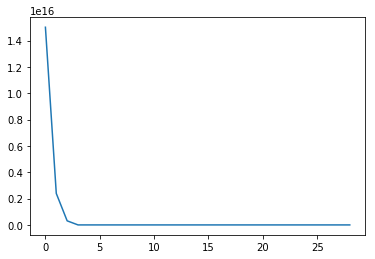

              feat_1    feat_2    feat_3    desc_1    desc_2    desc_3  year  \
listing_id                                                                     
6879986     0.696208  0.225298  0.078493  0.721063  0.199006  0.079931  2016   

            month  day  weekday    ...     price_per_bath  price_per_room  \
listing_id                         ...                                      
6879986         4   15        4    ...          3249.9675     1624.991875   

            price  bedrooms  bathrooms  strlen  numwords  numcaps  numpunct  \
listing_id                                                                    
6879986      3250         1        1.0     145        26      145         5   

            richness  
listing_id            
6879986     0.199999  

[1 rows x 29 columns]


In [198]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_transformed = pca.fit_transform(X_train_limited)
pca.fit(X_train_limited)
pca.explained_variance_ratio_
plt.plot(pca.explained_variance_)
plt.show()

print(X_train_limited.head(1))

In [199]:
num_comp = np.sum(np.cumsum(pca.explained_variance_ratio_) < .99)
print num_comp
X_limited_reduced = pca.transform(X_train_limited)[:, :num_comp]


2


In [200]:
comp0 = pd.Series(dict(zip(X_train_limited.columns, y_train)))
col_order = comp0.sort_values().index


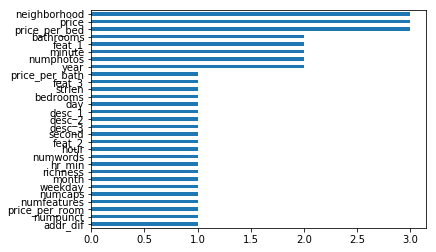

In [201]:
#plt.figure(figsize=(4, 24))
comp0[col_order].plot(kind='barh')
plt.show()
#why is year so high when they all have same one!? this seems wrong

In [202]:
feature_list = ['neighborhood','price','price_per_bed']

X_train_limited_reduced_pca_3 = X_train_limited[feature_list]
X_dev_limited_reduced_pca_3 = X_dev_limited[feature_list]

print(X_train.shape, X_dev.shape,
      X_train_limited_reduced_pca_3.shape, 
      X_dev_limited_reduced_pca_3.shape, 
      y_train.shape, 
      y_dev.shape)
accuracy_report('top3', X_train_limited_reduced_pca_3, 
                y_train, 
                X_dev_limited_reduced_pca_3,
                y_dev)


((39481, 42), (9871, 42), (39481, 3), (9871, 3), (39481,), (9871,))
RF Training Accuracy: 79.24% 	 Test Accuracy: 68.39%
RFC dev: 
             precision    recall  f1-score   support

          1       0.76      0.88      0.81      6797
          2       0.39      0.25      0.30      2334
          3       0.40      0.25      0.31       740

avg / total       0.64      0.68      0.66      9871

[[   1 7919]
 [   2 1477]
 [   3  475]]

features
['price_per_bed', u'price', 'neighborhood']
[ 0.39698603  0.36514268  0.23787129]
